In [1]:
import sys
sys.path.append('../') # To import from parent dir
import os

import time

import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import math

import util.GrammarBasedUtil as grammar_util
import util.valmod_uihe as valmod_util
from util.util import encoding_UiLog, read_data_for_processing, print_progress_bar

from experiment import run_experiment

import matplotlib as plt
import matplotlib.pyplot as plt

from itertools import chain

# LOCOmotif multi variate variable length motif discovery
# Source: https://github.com/ML-KULeuven/locomotif/tree/main
# Paper:  https://link.springer.com/article/10.1007/s10618-024-01032-z
import locomotif.locomotif as locomotif 
import util.locomotif_vis as visualize


import warnings
# Example: Only show a warning once globally
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
###########################################
### Step 1: Define UI hierarchy columns ###
###########################################

### Define UI hierarchy columns for the specific log ###
### The columns should be in order from higher level to lower level ###
### The example below is for Leno Action Logger Log ###
ui_hierarchy_system_cols = [] 
ui_hierarchy_application_cols = ["targetApp"] 
ui_hierarchy_ui_group_cols = ['url', 'target.workbookName'] 
ui_hierarchy_ui_element_cols = ['target.id', 'target.tagName', 'target.type', 'target.name', 'target.href'] 
ui_hierarchy_activity_cols = ['eventType'] 

### !! If there are nested UI groups, add more levels accordingly !! ###
### !! They must be added into the hierarchy list in the correct order as well !! ###
ui_hierarchy_ui_group1_cols1 = ['target.sheetName'] 

### Combine all hierarchy columns into a list ###
### Ignore empty levels ###
hierarchy_list = [ui_hierarchy_application_cols,ui_hierarchy_ui_group_cols,ui_hierarchy_ui_group1_cols1,ui_hierarchy_ui_element_cols]

### hierarchy_columns_app_switch is used to detect application switch events ###
### In Action Logger Logs this is only determined by the appliaction level ###
additional_context = [ui_hierarchy_system_cols,ui_hierarchy_application_cols]


#################################################
### Step 2: Define log location and file name ###
#################################################
log_file_path = "../logs/Leno/"
log_file_name = "202511_SR_RT_plus.csv"
sep_log = ";"  # Separator used in the log file

##################################################
### Step 3: Define Ground Truth for evaluation ###
##################################################

### Either provide a file with the columns [caseid,start_index,length,motif,end_index,total_occurances] ###
### The file should be in csv format ###
### or define the ground truth directly as a dataframe with the columns ###


gt_exists = True  # Set to True if ground truth file is provided
gt_file_path = "../logs/Leno/"
gt_file_name = "202511_SR_RT_plus_ground_truth.csv"
sep_gt = ";"  # Separator used in the ground truth file

# The ground truth file should have the following columns:
# 'caseid': The case identifier
# 'start_index': The start index of the motif in the log
# 'length': The length of the motif
# 'motif': The motif identifier
# 'end_index': The end index of the motif in the log
# 'total_occurances': The total number of occurrences of the motif

##################################################
### Step 4: Define rho parameter for LOCOmotif ###
##################################################
rho_LoCoMotif = 0.7

Run all cells from here on,  once you provided all necessary data

In [ ]:
hierarchy_columns = list(chain.from_iterable(hierarchy_list))
hierarchy_columns_app_switch = list(chain.from_iterable(additional_context))
column_identifier = 'w2v_'

log = pd.read_csv(os.path.join(log_file_path, log_file_name),sep=sep_log)
log = grammar_util.symbolize_UILog(log, hierarchy_columns)
if gt_exists:
    ground_truth = pd.read_csv(os.path.join(gt_file_path, gt_file_name),sep=sep_gt)
    if "end_index" not in ground_truth.columns:
        ground_truth["end_index"] = ground_truth["start_index"] + ground_truth["length"]

encoding_method = 1
rule_percentile_threshold = 0.90 # Percentile Threshold for Rule Density in Re-Pair >> Grammar Rule Peak is extended left and right until the rule count density drops below this percentile
rule_density_threshold = 0.8 # Threshold for Rule Density in Re-Pair >> Grammar Rule Peak is extended left and right until the rule count density drops below this threshold
app_switch_similarity_threshold = 0.75 # Threshold for considering a pattern drop in all discovered motifs as a pattern switch >> If less than x % share the same app, we consider this a switch
overlap_threshold = 0.8 # Threshold for considering a discovered motif as a true positive when overlapping at least this much with a ground truth motif >> Same as in Hohenadl 2025
safety_margin_factor = 5 # Factor to extend the safety margin around pattern switches detected in the grammar based analysis

**STEP 1: Grammar Based Core Detection** 

1. Read the data and gather the parameters for processing.
2. Generate Grammar
3. Generate Grammer Density Counts
4. Find Density Peaks and store as Grammar Based cores in "maximum_density_groups_df"

In [4]:
# Filter out hierarchy columns that have zero unique values
hierarchy_columns = [
    col for col in hierarchy_columns
    if log[col].nunique() != 0
]
tokens = 0
for col in hierarchy_columns:
    tokens += log[col].nunique()
token_based_vector_size = round(math.sqrt(tokens))

total_start_time = time.time()
# Apply the Grammar Based Rule Discovery and print a sample rule tree
encoding_df, symbols, two_gram_df = grammar_util.re_pair(log)
repair_time = time.time()
last_entry = len(encoding_df["new_symbol"])-1
last_encoding = encoding_df["new_symbol"].iloc[last_entry]
print("\n Last Rule Entry: ",last_encoding)
# Just for visualization purposes
# decoded_symbol = grammar_util.re_pair_decode_symbol(last_encoding, encoding_df, printing=True)
log = grammar_util.generate_density_count(encoding_df, log)
density_count_time = time.time()

# Find the maximum density groups based on the rule density count
max_density_groups_from_rules, _ = grammar_util.find_max_density_groups(log,relative_threshold=rule_density_threshold,method="percentile",percentile_threshold=rule_percentile_threshold)
maximum_density_groups_df = pd.DataFrame(columns=["group","processed"])
maximum_density_groups_df["group"] = max_density_groups_from_rules

# Add start and end indices to the dataframe
maximum_density_groups_df["start_index"] = -1
maximum_density_groups_df["end_index"] = -1
maximum_density_groups_df["length"] = 0
for i, grammer_motif in maximum_density_groups_df.iterrows():
    maximum_density_groups_df.loc[i, "start_index"] = min(grammer_motif['group'])
    maximum_density_groups_df.loc[i, "end_index"] = max(grammer_motif['group'])
    maximum_density_groups_df.loc[i, "length"] = maximum_density_groups_df.loc[i, "end_index"] - maximum_density_groups_df.loc[i, "start_index"] + 1
    
start_indices = maximum_density_groups_df["start_index"].tolist()
end_indices = maximum_density_groups_df["end_index"].tolist()
max_density_groups_time = time.time()


 Last Rule Entry:  mj


**Intermediary Visualisation** (Not Result Relevant)

Calculate the discovery scores for the grammar cores based on the ground truth.

Start Index of the first ground truth motif: 0
Maximum rule density count: 10
Longest identified motif length: 7


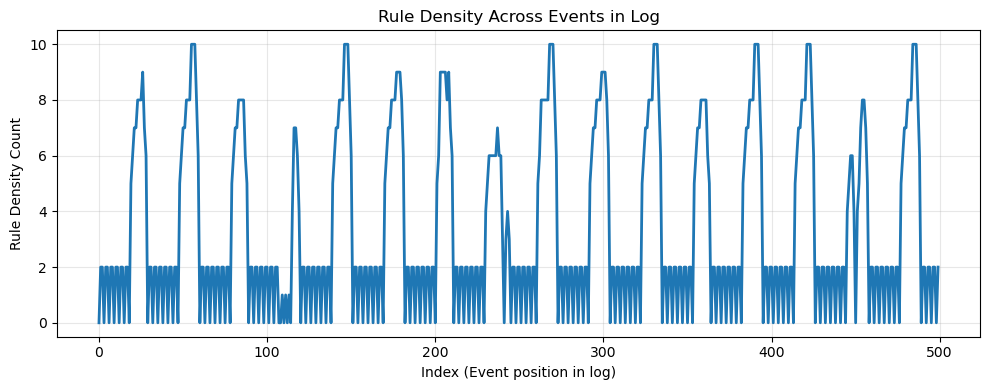

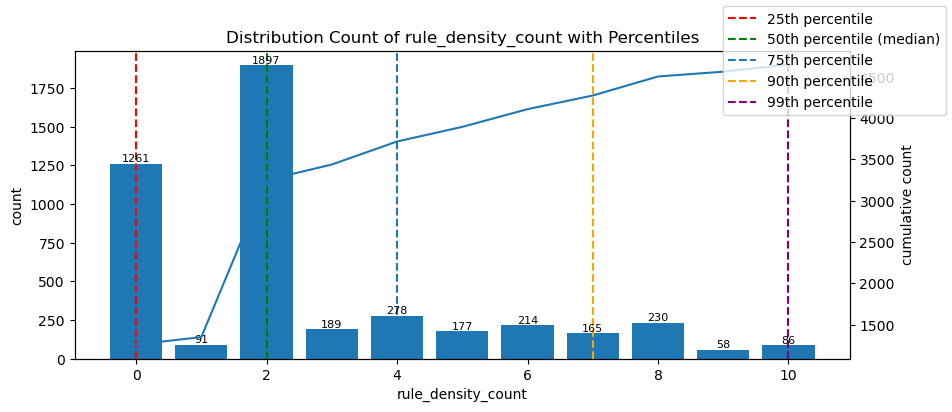

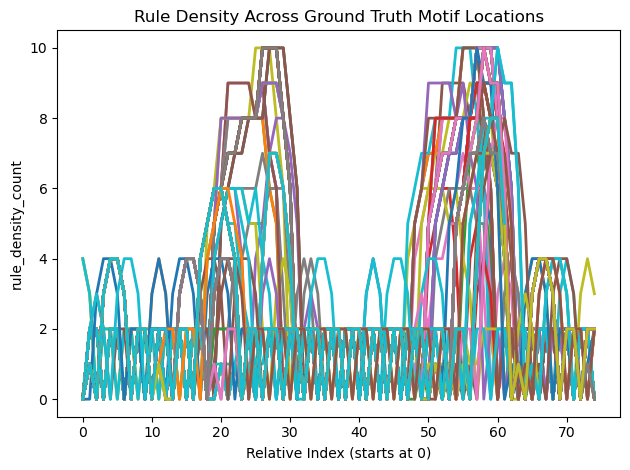

tp: 95.000
fp: 0.000
fn: 5.000
intersection_ratio: 1.000
intersection_abs: 5.674
undercount_ratio: 0.865
undercount_abs: 42.060
over_detection_ratio: 0.000
over_detection_abs: 0.000

Precision: 1.000, Recall: 0.950, F1: 0.974


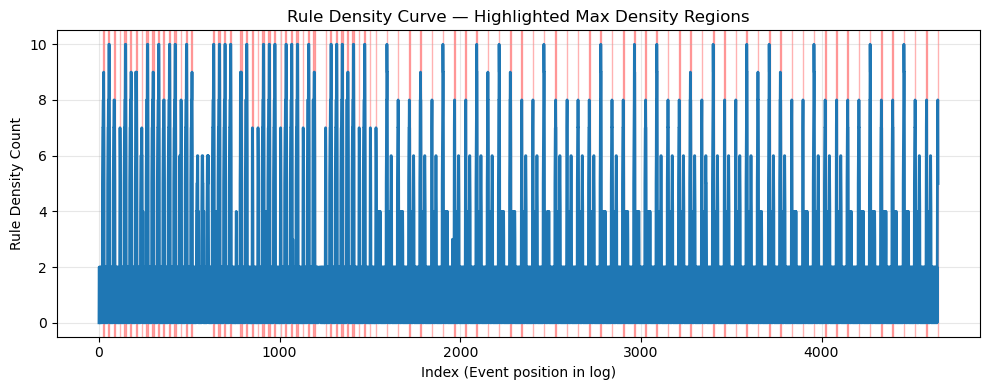

In [ ]:
# ---- Visualisation Only ---- No Logic for subsequent processing ----
if gt_exists:
    ground_truth.sort_values(by=["start_index"], inplace=True)
    motiv = int(ground_truth.iloc[0]["start_index"])
    print(f"Start Index of the first ground truth motif: {motiv}")
    colors = plt.cm.tab10.colors
    length = ground_truth["length"].max()
    ground_truth = ground_truth.astype({'caseid': 'str', 'start_index': 'int', 'length': 'int', 'end_index': 'int'})

print(f"Maximum rule density count: {log['rule_density_count'].max()}")
max_length = -1
min_length = len(log)
for motif in maximum_density_groups_df["group"]:
    if len(motif) > max_length:
       max_length = len(motif)
       if len(motif) > 0 and len(motif) < min_length:
            min_length = len(motif)
            print(f"Longest identified motif length: {max_length}")
            
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))
grammar_util.plot_rule_density_distribution(log, col_name="rule_density_count")

for i, start in enumerate(ground_truth["start_index"]):
    end = start+length+10
    y = log.iloc[int(start):int(end)]["rule_density_count"].to_numpy()
    x = range(len(y))  # all start at 0
    plt.plot(x, y, color=colors[i % len(colors)], linewidth=2, label=f"Range {start}-{end}")
    
plt.title("Rule Density Across Ground Truth Motif Locations") 
plt.xlabel("Relative Index (starts at 0)")
plt.ylabel("rule_density_count")
plt.tight_layout()
plt.show()

# ---- Evaluate the discovered motifs against the ground truth ----
if gt_exists:
    stats_new = grammar_util.evaluate_motifs(maximum_density_groups_df["group"], ground_truth, overlap_threshold)

    overlap_table = stats_new["overlap_table"]         # DataFrame for inspection
    tp, fp, fn = stats_new["tp"], stats_new["fp"], stats_new["fn"]
    for key, value in stats_new.items():
        if key != "overlap_table" and key != "matched_pairs":
            print(f"{key}: {value:.3f}")

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    # ---- Plotting the results ----
    plt.figure(figsize=(10, 4))
    plt.plot(log.index, log["rule_density_count"], linewidth=2)
    for g in max_density_groups_from_rules:
        plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
    plt.title("Rule Density Curve — Highlighted Max Density Regions")
    plt.xlabel("Index (Event position in log)")
    plt.ylabel("Rule Density Count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

**STEP 2: Context-Guided Log Reduction**

Identify app switches and filter the original log to rule-density based motif candidates

**STEP 3: Variable-Length Motif Discovery** 

Execute variable length motif discovery on the filtered log using LoCoMotif.

Total Included Range Length: 4639 of 4646
Percentage of Log Included: 99.85%
Using Word2Vec based encoding for UI Log
Parts of the log that are retained after filtering based on pattern switches and safety margins:


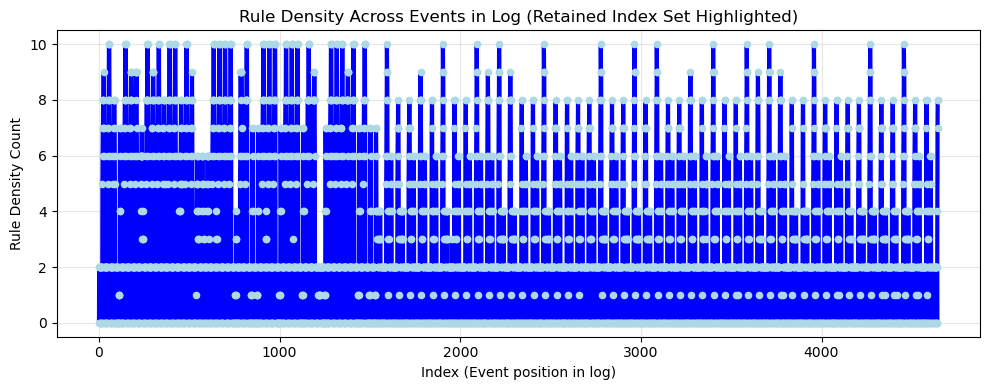

Rule Density Curve of first 500 Events before Filtering:


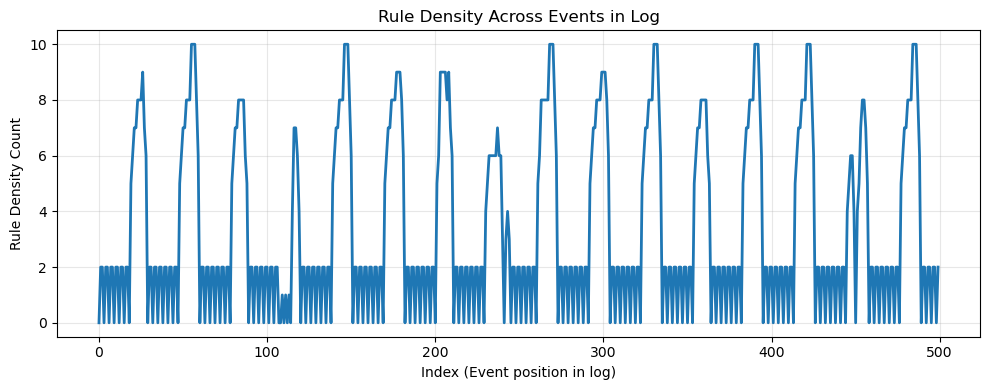

Rule Density Curve of first 500 Events after Filtering:


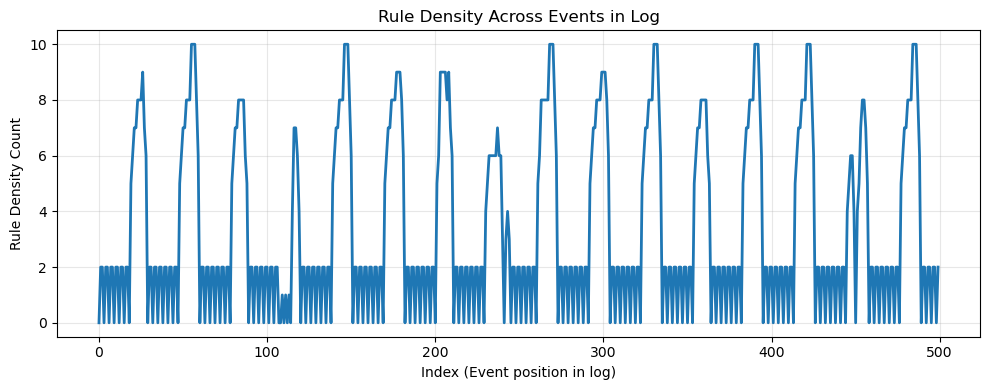

c:\Users\tomho\anaconda3\envs\tsrdWinter2025\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


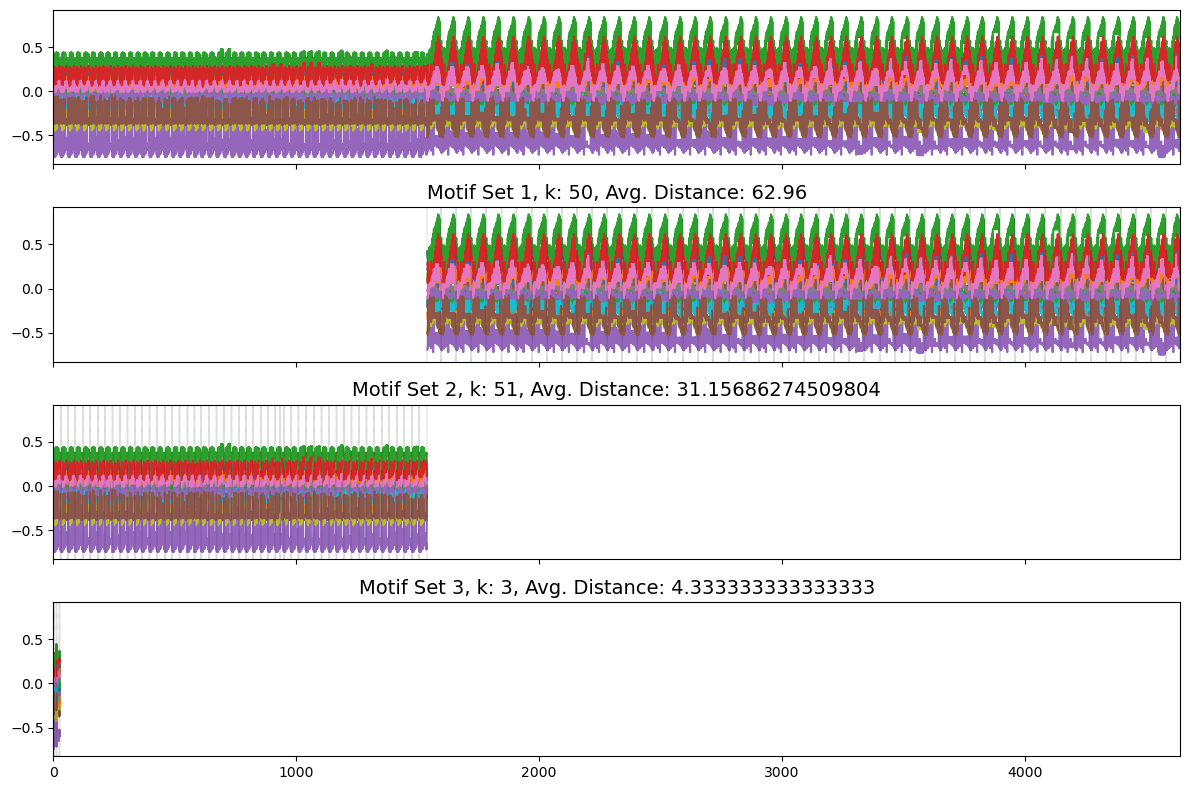

In [6]:
##################
##### Step 2 #####
##################

# Extend until the app changes for the specific pattern and add as "lower_app_switch" and "upper_app_switch"
max_groups_df = grammar_util.app_switch_miner(log, maximum_density_groups_df, hierarchy_columns_app_switch)
app_switch_mining_time = time.time()

lower_app_switches = max_groups_df["lower_app_switch"].tolist()
upper_app_switches = max_groups_df["upper_app_switch"].tolist()

# Mine the similar paths up and down until an app switch across discovered patterns is found
result_df = grammar_util.similar_path_up_down(
    df=log,
    max_groups_df=max_groups_df,
    start_indices=lower_app_switches,
    end_indices=upper_app_switches,
    cols=hierarchy_columns_app_switch,
    min_pairs=len(lower_app_switches)*app_switch_similarity_threshold, # At least 75% of the patterns should be similar in path
)


# build list of all valid index ranges
valid_indices = []

# Include additional safety margin from pattern switch
range_sum = 0
max_safety_margin = 0
for _, row in result_df.iterrows():
    # Set the safety margin as the distance between the pattern switches & apply factor to extend based on safety concern
    safety_margin = (int(row['upper_pattern_switch']) - int(row['lower_pattern_switch']))*safety_margin_factor
    if safety_margin > max_safety_margin:
        max_safety_margin = safety_margin
    valid_indices.extend(range(max(0, int(row['lower_pattern_switch'])-safety_margin),
                            min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1)))
    range_distance =  min(int(row['upper_pattern_switch'])+safety_margin, len(log)-1) - max(0, int(row['lower_pattern_switch'])-safety_margin)

# Generate Extended with all margins as list as well
max_groups_df['ext_group_list'] = max_groups_df.apply(lambda row: list(range(row['lower_pattern_switch'], row['upper_pattern_switch'] + 1)), axis=1)

# Convert the valid indices to a set to remove duplicates
valid_indices_set = set(valid_indices)
print(f"Total Included Range Length: {len(valid_indices_set)} of {len(log)}")
print(f"Percentage of Log Included: {len(valid_indices_set)/len(log)*100:.2f}%")

log_path_extension_time = time.time()

# filter log to include only those indices
filtered_log = log.loc[log.index.intersection(valid_indices)].copy()

# optionally, keep the original index as a column for traceability
filtered_log['original_index'] = filtered_log.index
filtered_log.reset_index(drop=True, inplace=True)

##################
##### Step 3 #####
##################

# Encode the filtered log
if encoding_method == 1:
    print("Using Word2Vec based encoding for UI Log")
    filtered_log_encoded = valmod_util.encode_word2vec(uiLog=filtered_log, 
                                                       orderedColumnsList=hierarchy_columns, 
                                                       vector_size=token_based_vector_size,
                                                       completeCorpusLog=log)
    column_identifier = 'w2v_'
elif encoding_method == 2:
    print("Using Hierarchical based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=1)
    column_identifier = 'tuple:id'
elif encoding_method == 3:
    print("Using Co-Occurrance based encoding for UI Log")
    filtered_log_encoded = encoding_UiLog(filtered_log,orderedColumnsList=hierarchy_columns,encoding=2)
    column_identifier = 'tuple:id'
else:
    raise ValueError("Invalid encoding method selected. Choose 1, 2, or 3.")

print("Parts of the log that are retained after filtering based on pattern switches and safety margins:")
grammar_util.plot_density_curve_with_index_set(log, valid_indices_set, column_name="rule_density_count")
df_filtered_for_plotting = filtered_log.reset_index(drop=True)
print("Rule Density Curve of first 500 Events before Filtering:")
grammar_util.plot_density_curve(log, range_low=0, range_high=min(500, len(log)))
print("Rule Density Curve of first 500 Events after Filtering:")
grammar_util.plot_density_curve(df_filtered_for_plotting, range_low=0, range_high=min(500, len(df_filtered_for_plotting)))

# Reduce the data to an ordered time series for locomotif
filtered_columns_reduced_log = filtered_log_encoded.filter(like=column_identifier)

# Optional: Normalization
ts = (filtered_columns_reduced_log - np.mean(filtered_columns_reduced_log, axis=None)) / np.std(filtered_columns_reduced_log, axis=None)

##########################################################
##### Variable Length Motif Discovery with LOCOmotif #####
##########################################################

# Calculate length statistics:
# l_min = Grammer Rule Density Length Mean - Std Dev
# l_max = Safety Margin from App switch analysis
l_min = max(5,maximum_density_groups_df["length"].mean() - maximum_density_groups_df["length"].std())
l_max = max_safety_margin

# Variable Length Motif Discovery >> Using the low from the GRAMMAR as l_min, Using the security margin from app switch as l_max
motif_sets = locomotif.apply_locomotif(filtered_columns_reduced_log, l_min=l_min, l_max=l_max, rho=rho_LoCoMotif)
locomotif_discovery_time = time.time()

# Plotting with adjusted locomotif visualization (utils)
fig, ax = visualize.plot_motif_sets(series=filtered_columns_reduced_log.values,
                                    motif_sets=motif_sets, 
                                    max_plots=5,
                                    legend=False)
plt.show()

**STEP 4: Grammer-Motif Alignment and Candidate Extraction**

Identify overlap between LOCOmotif and Re-Pair motifs to ensure that by the filtering step no additional motifs are inserted

In [ ]:
blocks = []

for cluster_set in motif_sets:# Efficient slicing instead of isin()
    for cluster_motif in cluster_set[1:]:
        for motif in cluster_motif:
            
            start_of_discovered_motif = motif[0]
            end_of_discovered_motif = motif[1]
            length_of_discovered_motif = end_of_discovered_motif - start_of_discovered_motif
            motif_original_start_index = filtered_log.loc[start_of_discovered_motif, "original_index"]
            # print(f"Motif Start Index: {start}, Motif Length: {end}")
            # print(f"Motif Original Start Index in Full Log: {motif_original_start_index}")
            try:
                block = pd.DataFrame({
                    "original_df_range": [list(range(motif_original_start_index, motif_original_start_index+length_of_discovered_motif))],
                    "cluster_id": [cluster_set[0]],
                    "original_df_case_ids": [log.loc[motif_original_start_index:motif_original_start_index+length_of_discovered_motif, "case:concept:name"].tolist()],
                    "motif_length": length_of_discovered_motif
                })
            except KeyError as ke:
                block = pd.DataFrame({
                    "original_df_range": [list(range(motif_original_start_index, motif_original_start_index+length_of_discovered_motif))],
                    "cluster_id": [cluster_set[0]],
                    "original_df_case_ids": [log.loc[motif_original_start_index:motif_original_start_index+length_of_discovered_motif, "caseid"].tolist()],
                    "motif_length": length_of_discovered_motif
                })
            blocks.append(block)
  
result_mapped_to_original_index = pd.concat(blocks, ignore_index=True)

result_mapped_to_original_index = grammar_util.mark_overlaps_grammer_locomotif_indexed(result_mapped_to_original_index, max_groups_df, col_df1="original_df_range", col_df2="ext_group_list")
total_end_time = time.time()

########################################
#### Discovery after Grammer Filter ####
########################################

# Filter the result to only include clusters with grammar motif matches

motif_df = result_mapped_to_original_index[
    result_mapped_to_original_index["grammer_motif_match"] == True
].copy()

motif_df = motif_df.reset_index(drop=True)   # index = motif_id = 0..M-1

### Here are the final results

In [12]:
motif_df

,original_df_range,cluster_id,original_df_case_ids,motif_length,grammer_motif_match
0,"[3774, 3775, 3776, 3777, 3778, 3779, 3780, 378...","(3774, 3837)","[86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 8...",63,True
1,"[3712, 3713, 3714, 3715, 3716, 3717, 3718, 371...","(3774, 3837)","[85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 8...",63,True
2,"[3836, 3837, 3838, 3839, 3840, 3841, 3842, 384...","(3774, 3837)","[87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 8...",63,True
3,"[3650, 3651, 3652, 3653, 3654, 3655, 3656, 365...","(3774, 3837)","[84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 8...",63,True
4,"[3898, 3899, 3900, 3901, 3902, 3903, 3904, 390...","(3774, 3837)","[88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 8...",63,True
...,...,...,...,...,...
95,"[89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 1...","(978, 1010)","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",32,True
96,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","(978, 1010)","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",30,True
97,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...","(978, 1010)","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",32,True
98,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(978, 1010)","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",30,True


**Evaluation on candidates**

Final evaluation on the discovery with total (not seperatey by cluster > see Step 9)
- Recall
- Precision
- F1-score
- Overlap Rates

Final Evaluation of Discovered Motifs against Ground Truth:
Considering **all** discovered motifs from LOCOmotif without filtering step
tp: 100.000
fp: 4.000
fn: 0.000
intersection_ratio: 1.037
intersection_abs: 47.058
undercount_ratio: 0.001
undercount_abs: 0.080
over_detection_ratio: -0.037
over_detection_abs: -1.385

Precision: 0.962, Recall: 1.000, F1: 0.980

Final Evaluation of Discovered Motifs against Ground Truth:
Considering only those motifs that were also identified by Grammar Based Discovery
tp: 98.000
fp: 2.000
fn: 2.000
intersection_ratio: 1.037
intersection_abs: 48.230
undercount_ratio: 0.021
undercount_abs: 0.650
over_detection_ratio: -0.037
over_detection_abs: -1.400
Precision: 0.980, Recall: 0.980, F1: 0.980


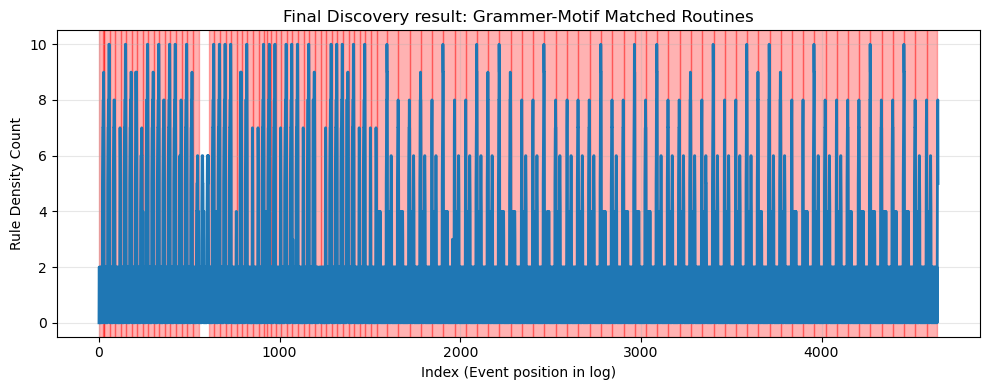

,motif,caseid,average_discovered_motif_length,precision,recall,f1,tp,fp,fn,required_total
0,RT,"[87, 86, 88, 85, 89, 84, 90, 83, 91, 82, 92, 8...",62.960000,1.000000,1.00,1.000000,50,0,0.0,50.0
1,SR,"[33, 32, 34, 28, 38, 27, 39, 26, 40, 31, 35, 2...",31.458333,0.979592,0.96,0.969697,48,1,2.0,50.0
2,UNMAPPED,-,0.000000,0.000000,0.00,0.000000,2,0,0.0,NaN


In [ ]:
if gt_exists:
    #########################################
    #### Discovery before Grammer Filter ####
    #########################################

    print("Final Evaluation of Discovered Motifs against Ground Truth:")
    print("Considering **all** discovered motifs from LOCOmotif without filtering step")

    final_discovery_result = grammar_util.evaluate_motifs(result_mapped_to_original_index["original_df_range"], ground_truth, overlap_threshold)

    overlap_table = final_discovery_result["overlap_table"]         # DataFrame for inspection
    tp, fp, fn = final_discovery_result["tp"], final_discovery_result["fp"], final_discovery_result["fn"]
    for key, value in final_discovery_result.items():
        if key != "overlap_table" and key != "matched_pairs":
            print(f"{key}: {value:.3f}")

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    print("\nFinal Evaluation of Discovered Motifs against Ground Truth:")
    print("Considering only those motifs that were also identified by Grammar Based Discovery")


    # Call evaluate_motifs with the aligned motif_df
    final_discovery_result = grammar_util.evaluate_motifs(
        motif_df["original_df_range"],
        ground_truth,
        overlap_threshold
    )

    overlap_table = final_discovery_result["overlap_table"]         # DataFrame for inspection
    tp, fp, fn = final_discovery_result["tp"], final_discovery_result["fp"], final_discovery_result["fn"]
    for key, value in final_discovery_result.items():
        if key != "overlap_table" and key != "matched_pairs":
            print(f"{key}: {value:.3f}")

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


    # ---- Plotting the results ---- 

    plt.figure(figsize=(10, 4))
    plt.plot(log.index, log["rule_density_count"], linewidth=2)
    for g in result_mapped_to_original_index[result_mapped_to_original_index["grammer_motif_match"] == True]["original_df_range"].to_list():
        plt.axvspan(g[0], g[-1], color="red", alpha=0.3)
    plt.title("Final Discovery result: Grammer-Motif Matched Routines")
    plt.xlabel("Index (Event position in log)")
    plt.ylabel("Rule Density Count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---- Calculating the results per Cluster ----
    cluster_based_evaluation_df = grammar_util.join_discovery_with_ground_truth(final_discovery_result, ground_truth, motif_df)
    motif_res = grammar_util.motif_level_metrics(cluster_based_evaluation_df)
    motif_purity = grammar_util.purity_per_two_columns(cluster_based_evaluation_df, cluster_by_col="motif", purity_col_name="cluster_id")

    cluster_res = grammar_util.cluster_level_metrics(cluster_based_evaluation_df)
    cluster_purity = grammar_util.purity_per_two_columns(cluster_based_evaluation_df, cluster_by_col="cluster_id", purity_col_name="motif")

    print(motif_res)

**Execution Time Results**

Compile execution times

In [ ]:
# The times that are necessary to execute the discovery steps
# Works only if executed in sequence as above and with ">> Run All" cells 
print(f"--- Timing Summary (in seconds) {log_file_name}---")
print(f"Total Execution Time: {total_end_time - total_start_time:.3f} seconds")
print(f"Re-Pair Time: {repair_time - total_start_time:.3f} seconds")
print(f"Density Count Time: {density_count_time - repair_time:.3f} seconds")
print(f"Max Density Groups Time: {max_density_groups_time - density_count_time:.3f} seconds")
print(f"App Switch Mining Time: {log_path_extension_time - app_switch_mining_time:.3f} seconds")
print(f"LOCOmotif Discovery Time: {locomotif_discovery_time - log_path_extension_time:.3f} seconds")

--- Timing Summary (in seconds) 202511_SR_RT_plus_extended.csv---
Total Execution Time: 140.172 seconds
Re-Pair Time: 2.332 seconds
Density Count Time: 4.067 seconds
Max Density Groups Time: 0.100 seconds
App Switch Mining Time: 0.165 seconds
LOCOmotif Discovery Time: 125.067 seconds
